In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import os
import PIL
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)



2.6.0


In [2]:
# get directory with images dataset
data_dir = pathlib.Path("images/keycap_images/")

# .glob() returns an object of a list of files with the given syntax
# convert to a list to access that list
image_count = len(list(data_dir.glob("*/*")))

print (f"Number of images: {image_count}")

# laser = list(data_dir.glob('GMK ThinkCaps/*'))
# PIL.Image.open(str(laser[0]))

Number of images: 589


In [3]:
# create data sets with keycap images
batch_size = 32
img_height = 200
img_width = 300
# create training dataset
# training dataset alters the weights and biases of the model
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 589 files belonging to 15 classes.
Using 501 files for training.


In [4]:
# create validation dataset
# validation training set used at the end of each epoch to evaluate
# the accuracy of the model
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 589 files belonging to 15 classes.
Using 88 files for validation.


In [5]:
# verify keycap set classes
class_names = train_ds.class_names
print(class_names)
num_classes = len(list(class_names))
print(num_classes)

['Astrolokeys', 'Blue Samurai', 'Carbon', 'Chalk', 'Ducky Frozen Llama', 'Ducky Joker', 'GMK Camping', 'GMK Momo Yume', 'GMK ThinkCaps', 'Honeywell', 'Laser', 'Nautilus', 'OEM Horizon', 'Pulse', 'Red Samurai']
15


In [6]:
# # visualizing the dataset
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [7]:
# conditioning datasets for performance (prevent I/O blocking)
# Dataset.cache keeps images in memory after they're loaded during the first epoch
# Dataset.pregetch overlaps data preprocessing and model execucution during training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# # standardize the [0,255] RGB values to [0,1] 
# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [9]:
# Data Augmentation: taking the images from the training dataset and
# augmenting them (flip, rotate, zoom) to create new training images
# We create a new layer that augments those images

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

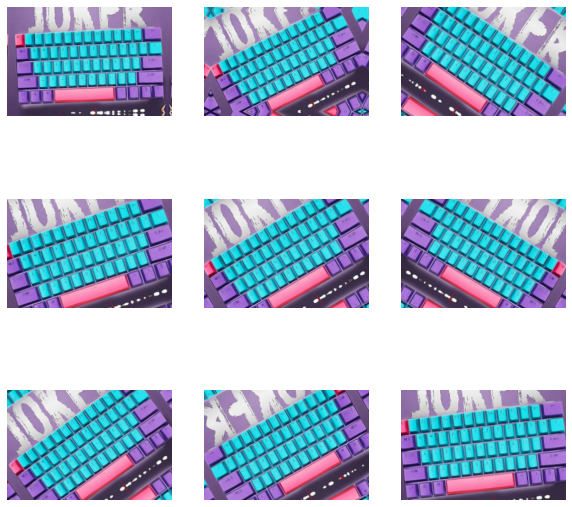

In [25]:
# Visualizing these newly generated images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [36]:
# new Sequential model that includes the augmentation layer and
# the dropout layer to prevent overfitting
model = Sequential()
## Input layer ##
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
## Hidden layers ##
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
# # drop 20% of output layer neurons, lessens overfitting
# model.add(layers.Dropout(0.2))
## take the 2D array of the image and flatten to a 1D
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='sigmoid'))
## Output layer ##
model.add(layers.Dense(num_classes))

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 200, 300, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 200, 300, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 200, 300, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 150, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 75, 64)       

In [38]:
# TRAINING THE UPDATED MODEL
# increase the number of epochs
epochs = 20
start_t = time.time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
end_t = time.time()
print("Time elapsed: " + str(end_t-start_t))

Epoch 1/20
16/16 [==============================] - 17s 953ms/step - loss: 2.6969 - accuracy: 0.1297 - val_loss: 2.4079 - val_accuracy: 0.2045
Epoch 2/20
16/16 [==============================] - 16s 991ms/step - loss: 2.1605 - accuracy: 0.2974 - val_loss: 1.8251 - val_accuracy: 0.3409
Epoch 3/20
16/16 [==============================] - 15s 956ms/step - loss: 1.7111 - accuracy: 0.4511 - val_loss: 1.6008 - val_accuracy: 0.3977
Epoch 4/20
16/16 [==============================] - 18s 1s/step - loss: 1.3223 - accuracy: 0.5848 - val_loss: 1.1122 - val_accuracy: 0.6136
Epoch 5/20
16/16 [==============================] - 16s 995ms/step - loss: 1.0286 - accuracy: 0.7265 - val_loss: 0.9649 - val_accuracy: 0.6932
Epoch 6/20
16/16 [==============================] - 15s 939ms/step - loss: 0.8344 - accuracy: 0.7645 - val_loss: 0.8207 - val_accuracy: 0.8068
Epoch 7/20
16/16 [==============================] - 16s 995ms/step - loss: 0.7046 - accuracy: 0.8303 - val_loss: 0.8151 - val_accuracy: 0.7386
Ep

Text(0.5, 1.0, 'Training and Validation Accuracy')

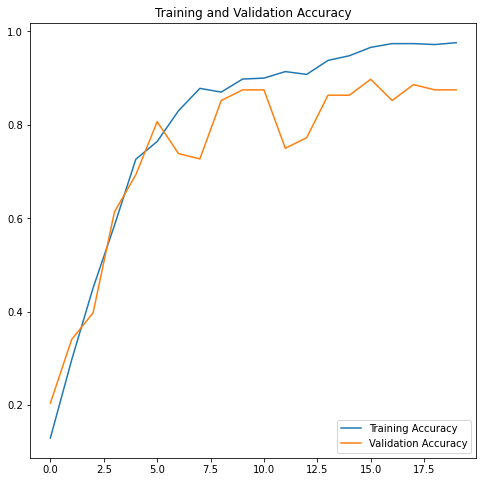

In [39]:
# plots of the loss and accurace on the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

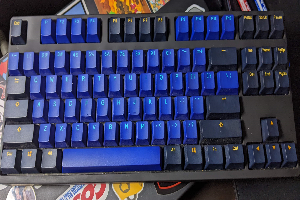

This image most likely belongs to OEM Horizon with a 78.50 percent confidence.
{'Astrolokeys': 0.052, 'Blue Samurai': 2.873, 'Carbon': 0.01, 'Chalk': 0.11, 'Ducky Frozen Llama': 2.22, 'Ducky Joker': 2.122, 'GMK Camping': 0.018, 'GMK Momo Yume': 0.08, 'GMK ThinkCaps': 0.05, 'Honeywell': 0.216, 'Laser': 12.618, 'Nautilus': 1.014, 'OEM Horizon': 78.499, 'Pulse': 0.061, 'Red Samurai': 0.056}


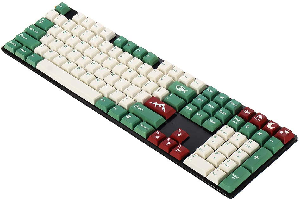

This image most likely belongs to GMK Camping with a 92.35 percent confidence.
{'Astrolokeys': 0.093, 'Blue Samurai': 0.07, 'Carbon': 1.418, 'Chalk': 3.459, 'Ducky Frozen Llama': 0.199, 'Ducky Joker': 0.079, 'GMK Camping': 92.349, 'GMK Momo Yume': 0.157, 'GMK ThinkCaps': 0.175, 'Honeywell': 0.507, 'Laser': 0.006, 'Nautilus': 0.089, 'OEM Horizon': 0.05, 'Pulse': 1.266, 'Red Samurai': 0.083}


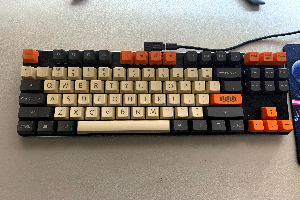

This image most likely belongs to Carbon with a 97.63 percent confidence.
{'Astrolokeys': 0.086, 'Blue Samurai': 0.095, 'Carbon': 97.629, 'Chalk': 0.125, 'Ducky Frozen Llama': 0.005, 'Ducky Joker': 0.004, 'GMK Camping': 0.234, 'GMK Momo Yume': 0.069, 'GMK ThinkCaps': 0.263, 'Honeywell': 0.201, 'Laser': 0.019, 'Nautilus': 0.433, 'OEM Horizon': 0.044, 'Pulse': 0.047, 'Red Samurai': 0.747}


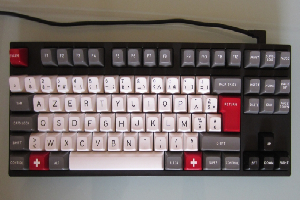

This image most likely belongs to Honeywell with a 94.69 percent confidence.
{'Astrolokeys': 0.242, 'Blue Samurai': 0.06, 'Carbon': 2.02, 'Chalk': 0.661, 'Ducky Frozen Llama': 0.025, 'Ducky Joker': 0.032, 'GMK Camping': 0.406, 'GMK Momo Yume': 1.412, 'GMK ThinkCaps': 0.072, 'Honeywell': 94.692, 'Laser': 0.127, 'Nautilus': 0.017, 'OEM Horizon': 0.152, 'Pulse': 0.018, 'Red Samurai': 0.063}


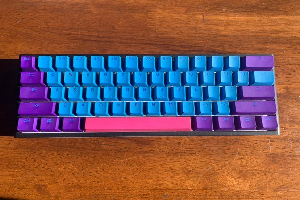

This image most likely belongs to Ducky Joker with a 76.06 percent confidence.
{'Astrolokeys': 0.087, 'Blue Samurai': 1.346, 'Carbon': 0.03, 'Chalk': 3.009, 'Ducky Frozen Llama': 11.572, 'Ducky Joker': 76.064, 'GMK Camping': 0.086, 'GMK Momo Yume': 0.072, 'GMK ThinkCaps': 0.065, 'Honeywell': 0.065, 'Laser': 0.369, 'Nautilus': 5.253, 'OEM Horizon': 0.43, 'Pulse': 1.141, 'Red Samurai': 0.41}


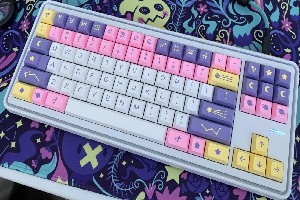

This image most likely belongs to Astrolokeys with a 85.88 percent confidence.
{'Astrolokeys': 85.882, 'Blue Samurai': 0.563, 'Carbon': 0.11, 'Chalk': 1.087, 'Ducky Frozen Llama': 1.196, 'Ducky Joker': 1.288, 'GMK Camping': 0.229, 'GMK Momo Yume': 7.226, 'GMK ThinkCaps': 0.04, 'Honeywell': 1.124, 'Laser': 0.765, 'Nautilus': 0.032, 'OEM Horizon': 0.259, 'Pulse': 0.038, 'Red Samurai': 0.162}


In [40]:
# Horizon test image
img = tf.keras.utils.load_img(
    'images/test/test.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

all_scores = {}
for idx,class_name in enumerate(class_names):
    all_scores[class_name] = round(100*score.numpy()[idx],3)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(all_scores)
#=================================================================#
# Camping test image
img = tf.keras.utils.load_img(
    'images/test/campingtest.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

all_scores = {}
for idx,class_name in enumerate(class_names):
    all_scores[class_name] = round(100*score.numpy()[idx],3)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(all_scores)
#=================================================================#
# Carbon test image
img = tf.keras.utils.load_img(
    'images/test/carbontest.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

all_scores = {}
for idx,class_name in enumerate(class_names):
    all_scores[class_name] = round(100*score.numpy()[idx],3)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(all_scores)
#=================================================================#
# Honeywell test image
img = tf.keras.utils.load_img(
    'images/test/honeywelltest.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

all_scores = {}
for idx,class_name in enumerate(class_names):
    all_scores[class_name] = round(100*score.numpy()[idx],3)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(all_scores)
#=================================================================#
# Joker test image
img = tf.keras.utils.load_img(
    'images/test/jokertest.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

all_scores = {}
for idx,class_name in enumerate(class_names):
    all_scores[class_name] = round(100*score.numpy()[idx],3)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(all_scores)#=================================================================#
# Astrolokeys test image
img = tf.keras.utils.load_img(
    'images/test/astrolokeystest.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

all_scores = {}
for idx,class_name in enumerate(class_names):
    all_scores[class_name] = round(100*score.numpy()[idx],3)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(all_scores)


In [41]:
import tarfile
# save the compiled and trained model
!mkdir -p saved_model
model.save("saved_model/")
# save the keycap set names list to a file for use on web server
listfile = open("saved_model/listfile.txt", "w")
for item in class_names:
    listfile.write(item + "\n")
listfile.close()
# tarball the saved_model


INFO:tensorflow:Assets written to: saved_model/assets
